In [1]:
WORKSPACE_NAME = 'merge_v1'
MODEL_NAME = 'efficientdet_d1_coco17_tpu-32'

In [2]:
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import time
import tensorflow as tf
import os
import pathlib
from toolz.curried import *

2022-12-31 11:30:12.014350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-31 11:30:20.444596: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-31 11:30:20.445553: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [3]:
from object_detection.utils import config_util, label_map_util 
from object_detection.utils import visualization_utils as viz_utils
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [4]:
MOUNT_POINT = '/home/jupyter'
TENSORFLOW = os.path.join(MOUNT_POINT,'cse496','Tensorflow')
NOTEBOOK_WS = os.path.join(TENSORFLOW,'workspace',WORKSPACE_NAME)
GIT = os.path.join(MOUNT_POINT, 'ocr-digital-display')
DS = os.path.join(MOUNT_POINT, 'ds')

In [5]:
paths = {
  'workspace': os.path.join(NOTEBOOK_WS),
  'labelmap': os.path.join(GIT,'tensorflow','label_map.pbtxt'),
  'models': os.path.join(TENSORFLOW,'models'),
  'train_record': os.path.join(DS,'train.record'),
  'test_record': os.path.join(DS,'test.record'),
  'scripts': os.path.join(TENSORFLOW,'scripts'),
  'pre_trained_models': os.path.join(TENSORFLOW,'pre-trained-models'),
  'pre_trained_model': os.path.join(TENSORFLOW,'pre-trained-models',MODEL_NAME),
  'model': os.path.join(NOTEBOOK_WS,'models',MODEL_NAME),
  'pipeline': os.path.join(NOTEBOOK_WS,'models',MODEL_NAME,'pipeline.config'),
  'train_script': os.path.join(TENSORFLOW,'models','research','object_detection','model_main_tf2.py'),
  'export_script': os.path.join(TENSORFLOW,'models','research','object_detection','exporter_main_v2.py'),
  'exported_models': os.path.join(NOTEBOOK_WS,'exported_models'),
  'exported_model': os.path.join(NOTEBOOK_WS,'exported_models',MODEL_NAME),
}

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(paths['labelmap'], use_display_name=True)

# Training Pipeline

In [21]:
!mkdir -p {paths['model']}

In [22]:
copy_pre_trained_model_command = 'cp {} {}'.format(
  os.path.join(paths['pre_trained_model'],'pipeline.config'),
  os.path.join(paths['model'],'pipeline.config'),
) 
copy_pre_trained_model_command 

'cp /home/jupyter/cse496/Tensorflow/pre-trained-models/efficientdet_d1_coco17_tpu-32/pipeline.config /home/jupyter/cse496/Tensorflow/workspace/merge_v1/models/efficientdet_d1_coco17_tpu-32/pipeline.config'

In [23]:
!{copy_pre_trained_model_command}

In [24]:
config = config_util.get_configs_from_pipeline_file(paths['pipeline'])

config

{'model': ssd {
   num_classes: 90
   image_resizer {
     keep_aspect_ratio_resizer {
       min_dimension: 640
       max_dimension: 640
       pad_to_max_dimension: true
     }
   }
   feature_extractor {
     type: "ssd_efficientnet-b1_bifpn_keras"
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: SWISH
       batch_norm {
         decay: 0.9900000095367432
         scale: true
         epsilon: 0.0010000000474974513
       }
       force_use_bias: true
     }
     bifpn {
       min_level: 3
       max_level: 7
       num_iterations: 4
       num_filters: 88
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 1.0
       x_scale: 1.0
       height_scale: 1.0
       width_scale: 1.0
     }
   }
   matcher {
     argmax_matc

In [25]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(paths['pipeline'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)
    
pipeline_config.model.ssd.num_classes = len(category_index)
#pipeline_config.model.ssd.loss.localization_weight = 0.8
#pipeline_config.model.ssd.loss.classification_weight = 1.3
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.num_steps = 25000
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['pre_trained_model'],'checkpoint','ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = 'detection'
pipeline_config.train_input_reader.label_map_path= paths['labelmap']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [paths['train_record']]
pipeline_config.eval_input_reader[0].label_map_path = paths['labelmap']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [paths['test_record']]

In [27]:
pipeline_config.train_config.data_augmentation_options.pop()

random_horizontal_flip {
}

In [28]:
pipeline_config

model {
  ssd {
    num_classes: 10
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 640
        max_dimension: 640
        pad_to_max_dimension: true
      }
    }
    feature_extractor {
      type: "ssd_efficientnet-b1_bifpn_keras"
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.029999999329447746
          }
        }
        activation: SWISH
        batch_norm {
          decay: 0.9900000095367432
          scale: true
          epsilon: 0.0010000000474974513
        }
        force_use_bias: true
      }
      bifpn {
        min_level: 3
        max_level: 7
        num_iterations: 4
        num_filters: 88
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 1.0
        x_scale: 1.0
        height_scale: 1.0
        width_scale: 1.

In [29]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(paths['pipeline'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

In [30]:
num_train_steps=25000
train_command = 'python {} --model_dir={} --pipeline_config_path={} --num_train_steps {}'.format(
    paths['train_script'], paths['model'], paths['pipeline'], num_train_steps
)

print(train_command)

python /home/jupyter/cse496/Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=/home/jupyter/cse496/Tensorflow/workspace/merge_v1/models/efficientdet_d1_coco17_tpu-32 --pipeline_config_path=/home/jupyter/cse496/Tensorflow/workspace/merge_v1/models/efficientdet_d1_coco17_tpu-32/pipeline.config --num_train_steps 25000


In [31]:
# Evaluation During Training: run parallel to training
eval_command = 'CUDA_VISIBLE_DEVICES="-1" python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}'.format(
    paths['train_script'],
    paths['model'],
    paths['pipeline'],
    paths['model']
)
print(eval_command)

CUDA_VISIBLE_DEVICES="-1" python /home/jupyter/cse496/Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=/home/jupyter/cse496/Tensorflow/workspace/merge_v1/models/efficientdet_d1_coco17_tpu-32 --pipeline_config_path=/home/jupyter/cse496/Tensorflow/workspace/merge_v1/models/efficientdet_d1_coco17_tpu-32/pipeline.config --checkpoint_dir=/home/jupyter/cse496/Tensorflow/workspace/merge_v1/models/efficientdet_d1_coco17_tpu-32


In [35]:
!{train_command}

2022-12-25 18:16:56.343522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 18:16:57.332660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-25 18:16:57.332752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [36]:
!mkdir -p {paths['exported_model']}
export_command = 'python {} --input_type image_tensor --pipeline_config_path {} --trained_checkpoint_dir {} --output_directory {}'.format(
    paths['export_script'],
    paths['pipeline'],
    paths['model'],
    paths['exported_model']
)

print(export_command)

python /home/jupyter/cse496/Tensorflow/models/research/object_detection/exporter_main_v2.py --input_type image_tensor --pipeline_config_path /home/jupyter/cse496/Tensorflow/workspace/merge_v1/models/efficientdet_d1_coco17_tpu-32/pipeline.config --trained_checkpoint_dir /home/jupyter/cse496/Tensorflow/workspace/merge_v1/models/efficientdet_d1_coco17_tpu-32 --output_directory /home/jupyter/cse496/Tensorflow/workspace/merge_v1/exported_models/efficientdet_d1_coco17_tpu-32


In [37]:
!{export_command}


2022-12-25 21:37:07.296103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 21:37:08.376273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-25 21:37:08.376663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

# Test

In [7]:
detect_fn = tf.saved_model.load(os.path.join(paths['exported_model'],'saved_model'))

2022-12-31 11:30:27.971126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 11:30:28.192512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 11:30:28.194349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 11:30:28.197767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [71]:
def load_image_into_numpy_array(path):
  return pipe(
      path,
      Image.open,
      #lambda x: x.convert('RGB'),
      np.array,
      #lambda x: np.expand_dims(x, axis=0)
      #lambda x: x[np.newaxis, :]
  )

def detect(image_path):
  return pipe(
      image_path,
      load_image_into_numpy_array,
      lambda im: pipe(
        im,
        tf.convert_to_tensor,
        lambda x: x[tf.newaxis, ...],
        #lambda x: print(x.shape)
        detect_fn,
        lambda detections: merge(detections, {'image': im})
      )
  )

def get_imgs(path):
    return pipe(
        os.path.join(path),
        os.listdir,
        map(lambda x: os.path.join(path,x)),
        filter(lambda x: any((
            x.endswith('jpeg'),
            x.endswith('jpg')
        ))),
        take(10)
    )


def auto_thickness(im):
    return pipe(
        im,
        np.shape,
        lambda hw: hw[0]*hw[1]*0.000002,
        int,
        lambda x: x if x > 1 else 1,
    )

def visualize(detections):
    viz_utils.visualize_boxes_and_labels_on_image_array(
      detections['image'],
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy()).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,     
      min_score_thresh=.2,      
      line_thickness=auto_thickness(detections['image']),
      skip_scores=True,
      agnostic_mode=False
    )
    
def display(im):
    %matplotlib inline
    plt.figure(figsize = (24,24))
    plt.imshow(im)
    plt.axis('off')
    plt.show()

2


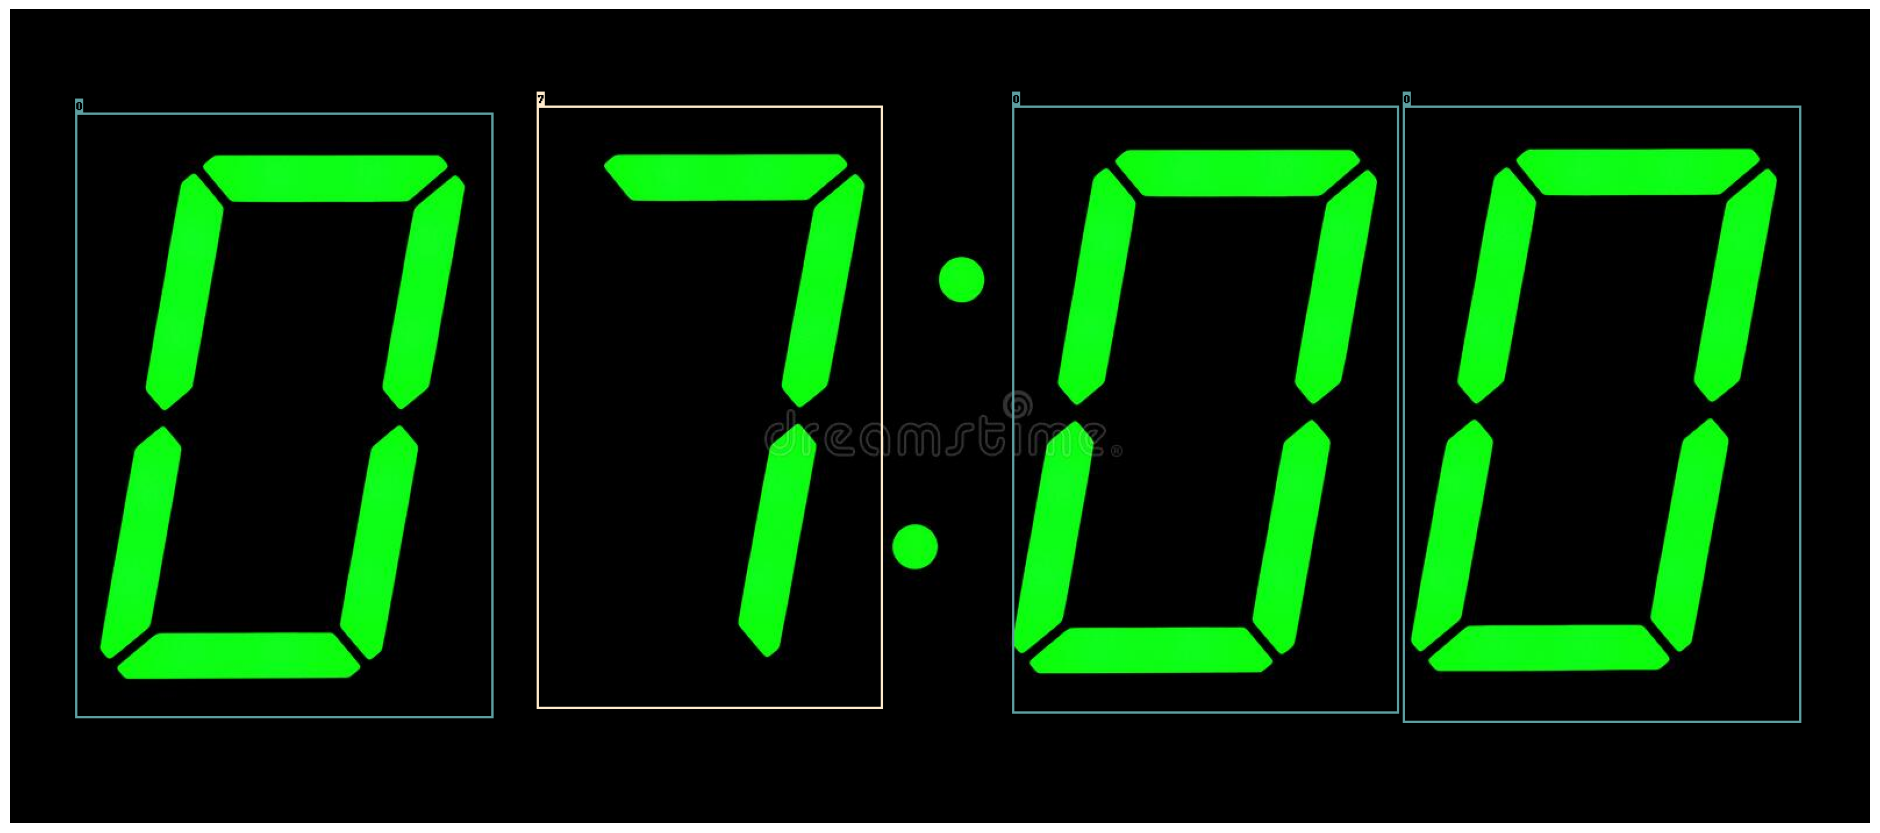

9


8


In [ ]:
for image_path in get_imgs('/home/jupyter/test'):
    detections = detect(image_path)
    visualize(detections)
    display(detections['image'])

4.0

# Reset GPU

In [69]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()